In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf

In [2]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
dfs = load_train_test_data(data_directory, train_or_test = "all")
train_init = dfs[0]
test_init = dfs[1]
gene_stats = dfs[2]

In [3]:
# drop the string values
train_df = train_init.drop(columns= ["DepMap_ID", "age_and_sex"])
test_df = test_init.drop(columns= ["DepMap_ID", "age_and_sex"])

In [4]:
# subsetting the genes 
# create dataframe containing the 1000 genes with the largest variances and their corresponding gene label and extract the gene labels
largest_var_df = gene_stats.nlargest(1000, "variance")
gene_list = largest_var_df["gene_ID"].tolist()
gene_list

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list, axis = 1)
subset_test_df = test_df.filter(gene_list, axis = 1)

In [5]:
print(subset_train_df.shape)
subset_train_df.head(3)

(751, 1000)


,GPX4 (2879),ITGAV (3685),CDK6 (1021),SCAP (22937),CCND1 (595),FERMT2 (10979),TYMS (7298),PCYT1A (5130),SDHB (6390),CFLAR (8837),...,TCERG1 (10915),MRPL49 (740),URM1 (81605),BRAP (8315),CCDC144A (9720),EXOC2 (55770),TCOF1 (6949),UBE3D (90025),PARN (5073),GSDMA (284110)
0,0.011581,0.770145,0.932997,0.054943,0.999962,0.909631,0.094852,0.117865,0.427640,0.190956,...,0.616313,0.244505,0.769569,0.291900,0.558567,0.760100,0.932975,0.031527,0.277917,0.314233
1,0.053997,0.009904,0.367195,0.001506,0.994464,0.015096,0.880810,0.905601,0.949642,0.726629,...,0.272177,0.154228,0.898438,0.388043,0.673615,0.199419,0.985815,0.160459,0.818588,0.829236
2,0.134245,0.055602,0.024801,0.317717,0.085127,0.269408,0.987037,0.014647,0.847858,0.106740,...,0.121123,0.871377,0.721131,0.229842,0.194259,0.092700,0.844732,0.124325,0.340351,0.344487


In [6]:
print(subset_test_df.shape)
subset_test_df.head(3)

(133, 1000)


,GPX4 (2879),ITGAV (3685),CDK6 (1021),SCAP (22937),CCND1 (595),FERMT2 (10979),TYMS (7298),PCYT1A (5130),SDHB (6390),CFLAR (8837),...,TCERG1 (10915),MRPL49 (740),URM1 (81605),BRAP (8315),CCDC144A (9720),EXOC2 (55770),TCOF1 (6949),UBE3D (90025),PARN (5073),GSDMA (284110)
0,0.099350,0.849009,0.023172,0.599967,0.087205,0.135586,0.995883,0.948425,0.892461,0.648334,...,0.843236,0.876208,0.758239,0.377978,0.648197,0.678042,0.977397,0.035103,0.389403,0.207370
1,0.821185,0.052062,0.208097,0.928353,0.978505,0.249416,0.016701,0.371935,0.857939,0.864571,...,0.776906,0.813475,0.934780,0.245852,0.625234,0.042365,0.812659,0.113039,0.415324,0.681331
2,0.970077,0.183512,0.909020,0.970670,0.126900,0.148982,0.969827,0.929632,0.893441,0.094053,...,0.539989,0.961715,0.870768,0.101138,0.502977,0.136978,0.961490,0.020495,0.230682,0.366392


In [7]:
# scale the data
def absolute_maximum_scale(series):
    return series / series.abs().max()


for col in subset_train_df.columns:
    subset_train_df[col] = absolute_maximum_scale(subset_train_df[col])
for col in subset_test_df.columns:
    subset_test_df[col] = absolute_maximum_scale(subset_test_df[col])


In [8]:
encoder_architecture = []
decoder_architecture = []

In [9]:
cp_vae = VAE(
    input_dim=subset_train_df.shape[1],
    latent_dim=10,
    batch_size=16,
    encoder_batch_norm=False,
    epochs=40,
    learning_rate=0.005,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1.6,
    lam=0,
    verbose=True,
)

cp_vae.compile_vae()

2022-07-26 08:47:58.441164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-26 08:47:58.866470: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9284 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:41:00.0, compute capability: 8.6
/home/markw/miniconda3/envs/test01/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
cp_vae.train(x_train = subset_train_df, x_test = subset_test_df)

Epoch 1/40
44/47 [===========================>..] - ETA: 0s - loss: 157.6667 - recon: 138.6220 - kl: 19.0446

2022-07-26 08:48:00.592419: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


47/47 [==============================] - 2s 8ms/step - loss: 153.5233 - recon: 134.7433 - kl: 18.7800 - val_loss: 99.6516 - val_recon: 84.5147 - val_kl: 15.1369
Epoch 2/40
47/47 [==============================] - 0s 5ms/step - loss: 90.1295 - recon: 78.3192 - kl: 11.8103 - val_loss: 93.8610 - val_recon: 79.8958 - val_kl: 13.9652
Epoch 3/40
47/47 [==============================] - 0s 4ms/step - loss: 86.8978 - recon: 74.0795 - kl: 12.8183 - val_loss: 87.6619 - val_recon: 74.9817 - val_kl: 12.6803
Epoch 4/40
47/47 [==============================] - 0s 4ms/step - loss: 83.0833 - recon: 70.0618 - kl: 13.0215 - val_loss: 85.9029 - val_recon: 74.2378 - val_kl: 11.6651
Epoch 5/40
47/47 [==============================] - 0s 4ms/step - loss: 80.4886 - recon: 68.0588 - kl: 12.4298 - val_loss: 83.6359 - val_recon: 71.1607 - val_kl: 12.4753
Epoch 6/40
47/47 [==============================] - 0s 5ms/step - loss: 78.5660 - recon: 66.3585 - kl: 12.2075 - val_loss: 83.2882 - val_recon: 70.7394 - val_k

In [11]:
# display training history
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,recon,kl,val_loss,val_recon,val_kl
0,153.523346,134.743347,18.779982,99.651604,84.514664,15.136947
1,90.129471,78.319199,11.810279,93.860970,79.895782,13.965187
2,86.897835,74.079506,12.818328,87.661926,74.981659,12.680264
3,83.083321,70.061806,13.021513,85.902878,74.237793,11.665086
4,80.488586,68.058815,12.429766,83.635941,71.160652,12.475279
5,78.565994,66.358475,12.207533,83.288193,70.739357,12.548843
6,77.491447,65.767136,11.724327,81.399376,70.870987,10.528398
7,75.930595,64.676369,11.254217,82.681381,73.498535,9.182854
8,75.953583,64.615631,11.337969,80.068886,69.416443,10.652453
9,74.348648,63.755566,10.593101,77.035698,66.003639,11.032063


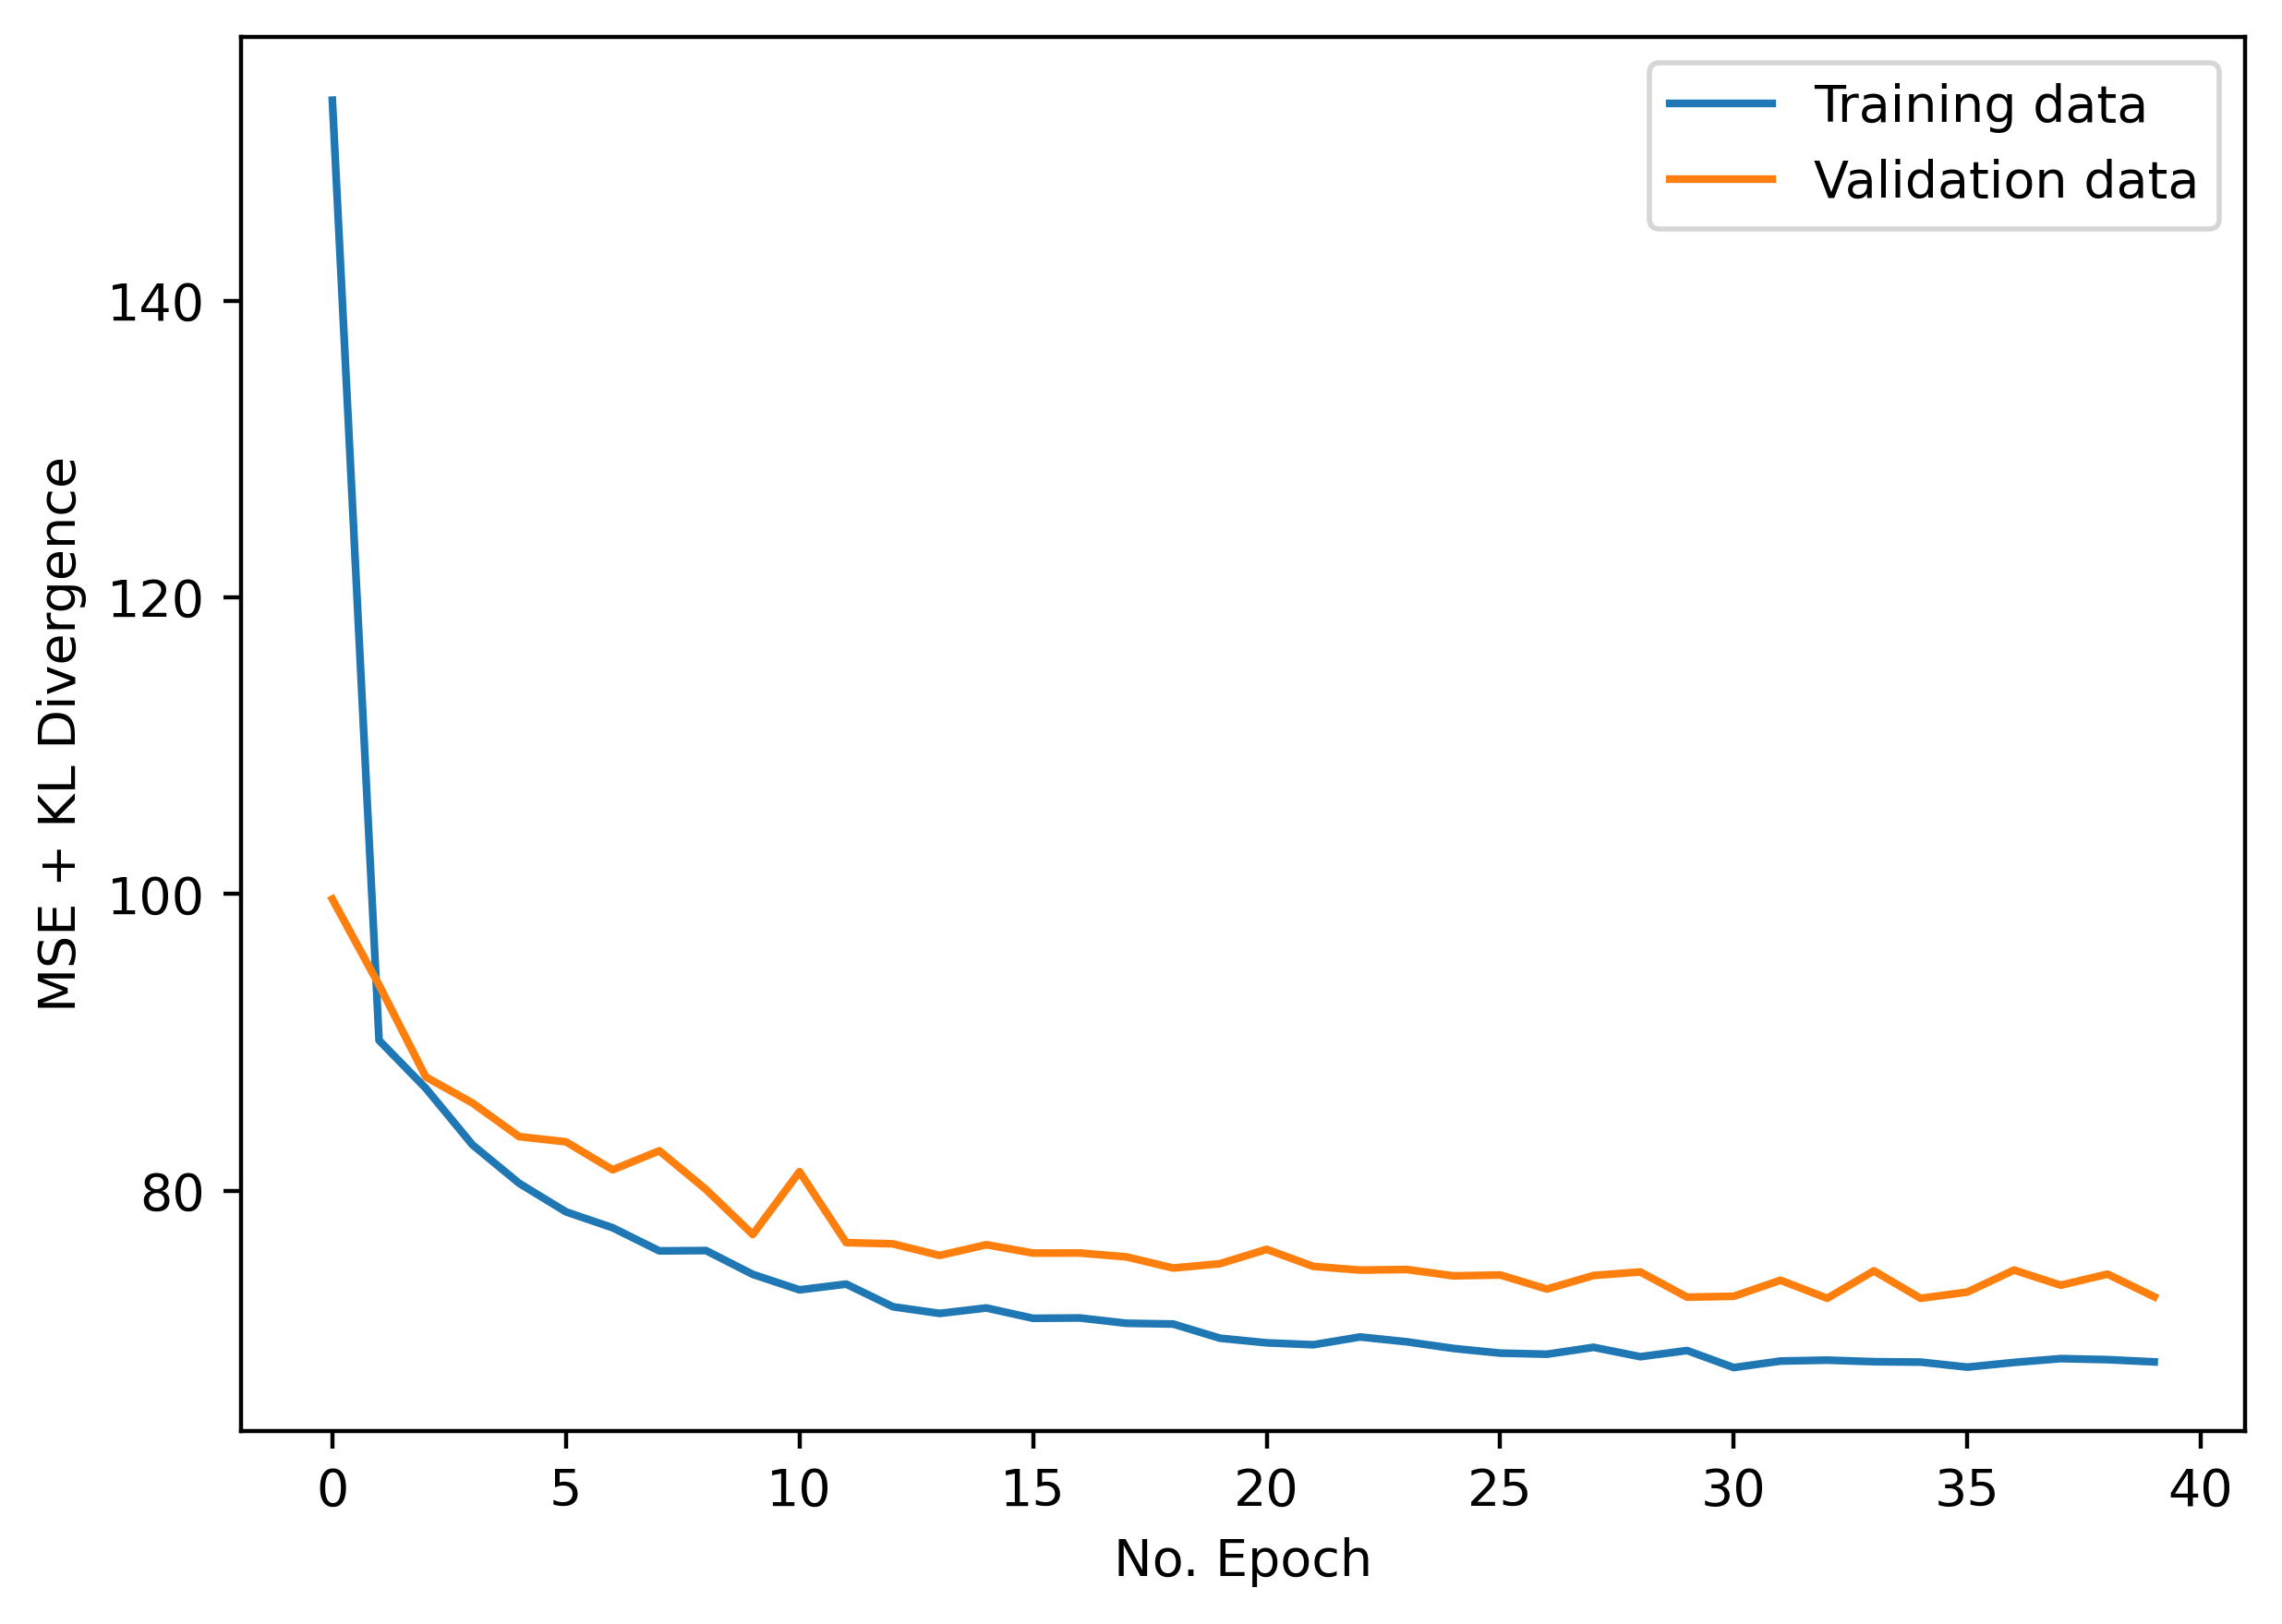

In [12]:
# plot and save the figure
save_path = pathlib.Path('../1.data-exploration/figures/training_curve.png')

plt.figure(figsize=(7, 5), dpi = 400)
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("No. Epoch")
plt.legend()
plt.savefig(save_path)
plt.show()